In [1]:
%matplotlib inline

import os, re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from joblib import dump, load

In [2]:
random_state = 42

# Loading the dataset

The dataset contains sales data of used cars. The goal is to predict the target price of the car.

## Attributes description

- **id**: an integer unically identifying a car ad
- **date**: the date the ad was published
- **categoy**: the category of the car
- **energy**: the energy the car uses
- **range**: the distance the car already traveled
- **color**: the color of the car
- **papers**: the type of legal documents the owner has
- **transmission**: the type of transmission of the car
- **offer**: the type of deal the owner accepts
- **wilaya**: the wilaya the ad was published from
- **town**: the town the ad was published from, relative to the wilaya
- **brand**: the brand of the car
- **model**: the model of the car, relative to the brand
- **year**: the year the car was initially bought
- **volume**: the consumption of the engine
- **horses**: the number of horses of the engine
- **climatisation, ...**: those are additional options of the car
- **price**: the target price of the car

The problem is a regression problem were the model has to predict the price of car.

The goal of the final model is to suggest a range of prices for a given car, and it will typically be used as a web application.

In [3]:
df_full = pd.read_csv(os.path.abspath('dataset/cars_cleaned.csv'))

In [4]:
len(df_full)

16832

In [5]:
df_full.head()

,id,date,category,energy,range,color,papers,transmission,price,offer,...,direction assisstée,climatisation,jantes alliage,esp,vitres éléctriques,retroviseurs électriques,phares antibrouillard,phares xénon,feux du jour,abs
0,27661724,27-07-2021,moyenne berline,diesel,56000,blanc,carte grise (safia),manuelle,410.0,négociable,...,1,1,1,1,1,1,1,1,1,1
1,27661710,27-07-2021,commerciale,essence,2,gris,carte grise (safia),manuelle,138.0,fixe,...,0,0,0,0,0,0,0,0,0,0
2,27661707,27-07-2021,citadine,diesel,10,gris,carte grise (safia),manuelle,305.0,négociable,...,1,1,0,0,1,1,1,0,0,1
3,27661699,27-07-2021,citadine,essence,277000,blanc,carte grise (safia),manuelle,150.0,offert,...,1,1,1,1,1,1,0,0,0,1
4,27661693,27-07-2021,mini citadine,essence,18000,bleu,carte grise (safia),manuelle,63.0,fixe,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16832 entries, 0 to 16831
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        16832 non-null  int64  
 1   date                      16832 non-null  object 
 2   category                  16832 non-null  object 
 3   energy                    16832 non-null  object 
 4   range                     16832 non-null  int64  
 5   color                     16734 non-null  object 
 6   papers                    16832 non-null  object 
 7   transmission              16832 non-null  object 
 8   price                     16832 non-null  float64
 9   offer                     16832 non-null  object 
 10  wilaya                    16828 non-null  object 
 11  town                      16827 non-null  object 
 12  brand                     16832 non-null  object 
 13  model                     16832 non-null  object 
 14  year  

Most of the attributes are nominal categorical attributes.

The data takes only ~ 4 MB of space. So loading the whole dataset will not result in any performance decrease.

In [7]:
df_full['date'] = pd.to_datetime(df_full['date'])

In [8]:
df = df_full.copy()

# Exploratory data analysis

<AxesSubplot:>

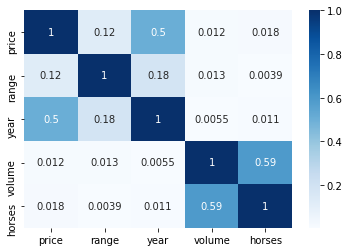

In [9]:
sns.heatmap(df[['price', 'range', 'year', 'volume', 'horses']].corr().abs(), annot = True, cmap = 'Blues')

There is strong correlation between volume and horses. We can replace these two features with a combination of them, but since they both have low correlation with the target price it will not be necessary.

We note also that the year has strong correlation with the price.

## Missing values

In [10]:
df.isna().sum()

id                             0
date                           0
category                       0
energy                         0
range                          0
color                         98
papers                         0
transmission                   0
price                          0
offer                          0
wilaya                         4
town                           5
brand                          0
model                          0
year                           0
volume                      1862
horses                      3743
radar de recul                 0
toit ouvrant                   0
alarme                         0
direction assisstée            0
climatisation                  0
jantes alliage                 0
esp                            0
vitres éléctriques             0
retroviseurs électriques       0
phares antibrouillard          0
phares xénon                   0
feux du jour                   0
abs                            0
dtype: int

Since the data has high variance, we cannot replace missing volume or horses number, which are important for predicting price. Otherwise, we will end up heavily influencing the models.

On the other hand, there are considerably less missing colors values, which will be filled by the mode value.

There are also 4 and 5 missing wilayas and towns respectively. They will be dropped as well.

We will not use a generic pipeline, since we do not expect hightly unstructured data in the future. The model will rather be served on custom platform that ensure all future samples do not have missing values.

In [11]:
df.dropna(subset = ['wilaya', 'town', 'volume', 'horses'], axis = 0, inplace = True)
df['color'].fillna(df['color'].mode(), inplace = True)

## train-test split

In [12]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = random_state)
df_train = train_set.copy()

## Numerical features

year, range, volume, horses

### year

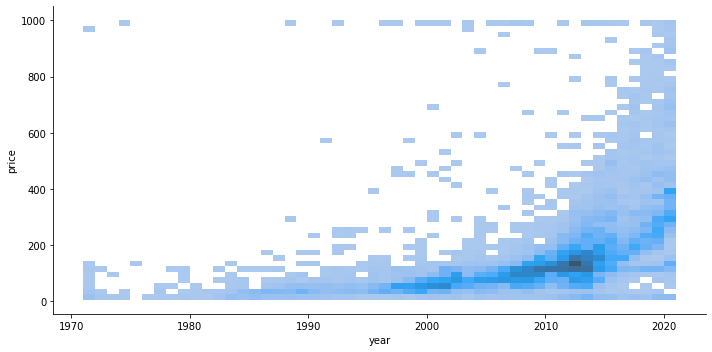

In [13]:
sns.displot(kind = 'hist', data = df_train, x = 'year', y = 'price', bins = 50, aspect = 2)

The price seems to be capped at 1000, we may want to remove prices around 1000 so the model does not learn missleading patterns.

### range

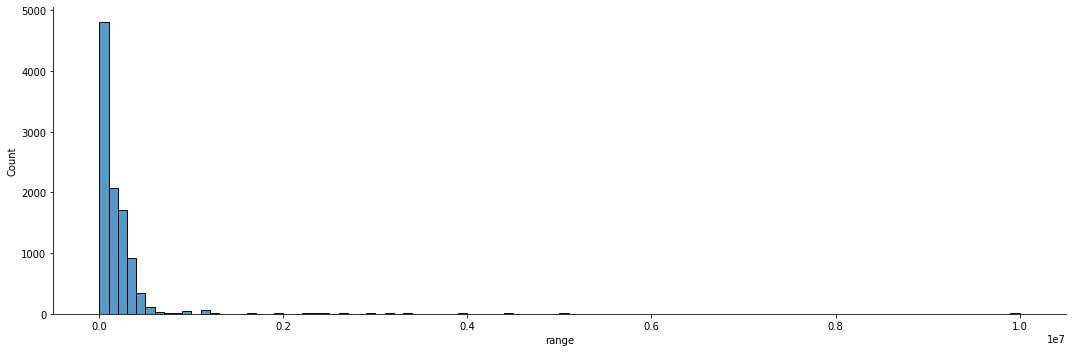

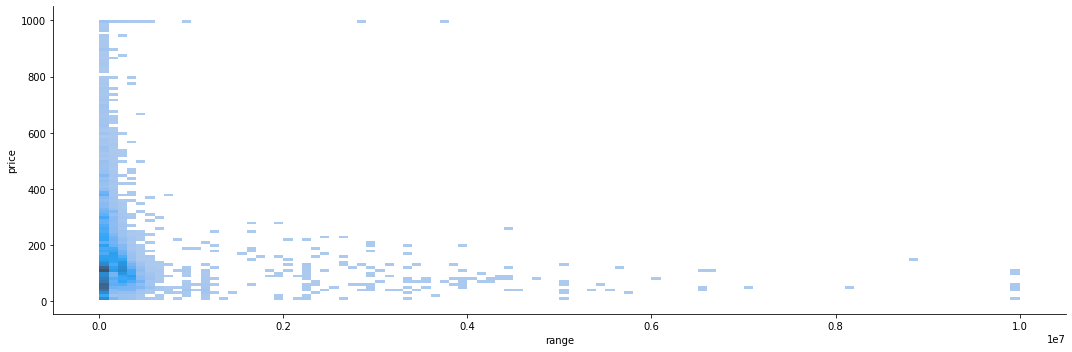

In [14]:
sns.displot(kind = 'hist', data = df_train, x = 'range', bins = 100, aspect = 3)
sns.displot(kind = 'hist', data = df_train, x = 'range', y = 'price', bins = 100, aspect = 3)

We conclude that prices tend to be higher for new cars with least range (again those two features are correlated).

In [15]:
df_train['range'].skew()

10.186681254655964

Skew is important on range, we will apply a log transformation to reduce skewness.

In [16]:
df_train['range'] = df_train['range'].map(lambda x: np.log(x) if x > 0 else x)

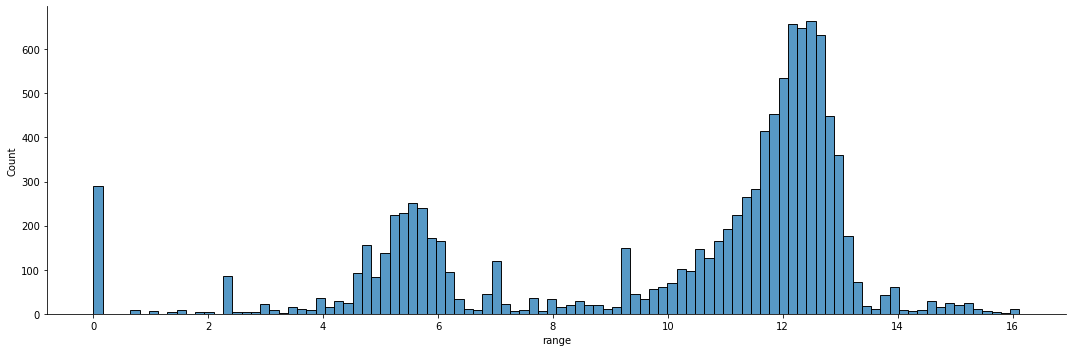

In [17]:
sns.displot(kind = 'hist', data = df_train, x = 'range', bins = 100, aspect = 3)

In [18]:
df_train['range'].skew()

-1.1518829910091601

We have to apply the same transformation on the test and new samples. So we will add this transformation to the final pipeline.

### volume

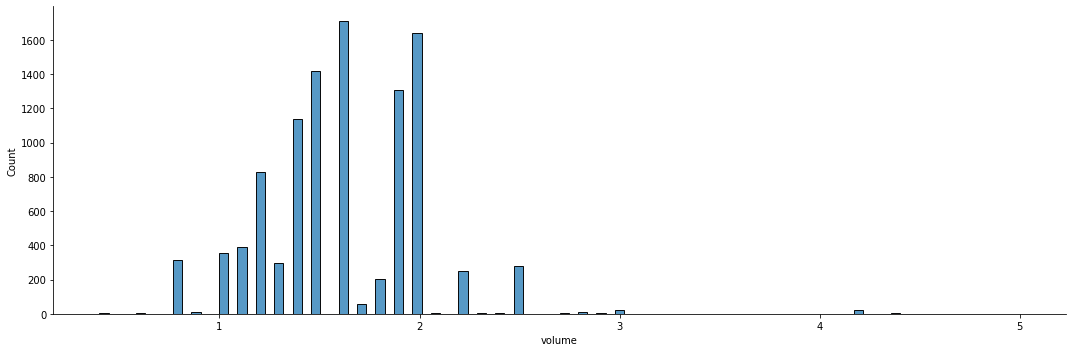

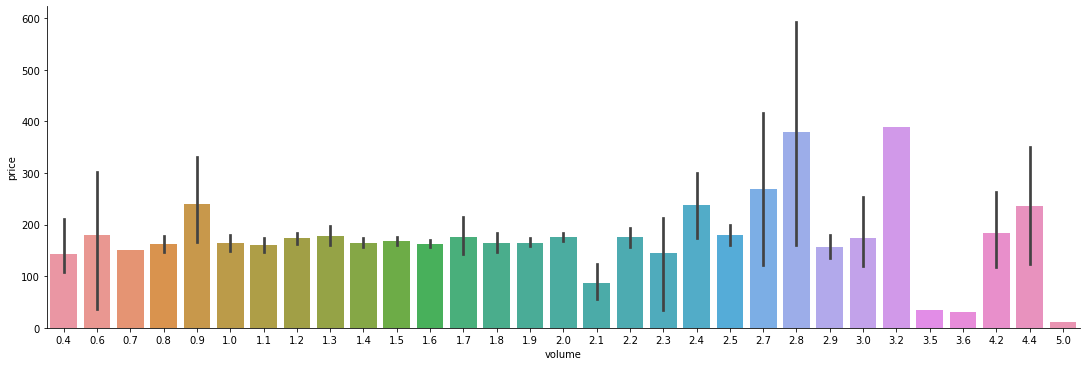

In [19]:
sns.displot(kind = 'hist', data = df_train, x = 'volume', bins = 100, aspect = 3)
sns.catplot(kind = 'bar', data = df_train, x = 'volume', y = 'price', aspect = 3)

### horses

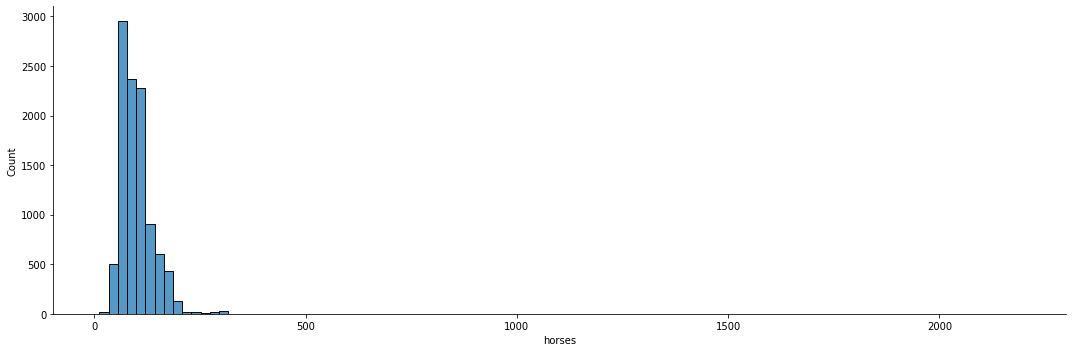

In [20]:
sns.displot(kind = 'hist', data = df_train, x = 'horses', bins = 100, aspect = 3)

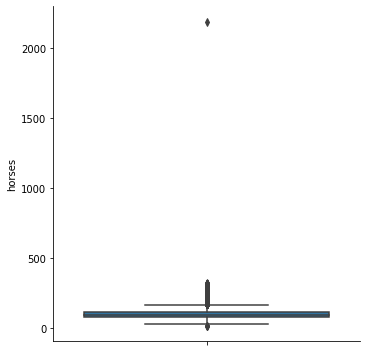

In [21]:
sns.catplot(kind = 'box', data = df_train, y = 'horses')

It seems that there are some outliers for the number of horses.

## Categorical features

date, category, energy, color, papers, transmission, offer, wilaya, town, brand, model 

### date

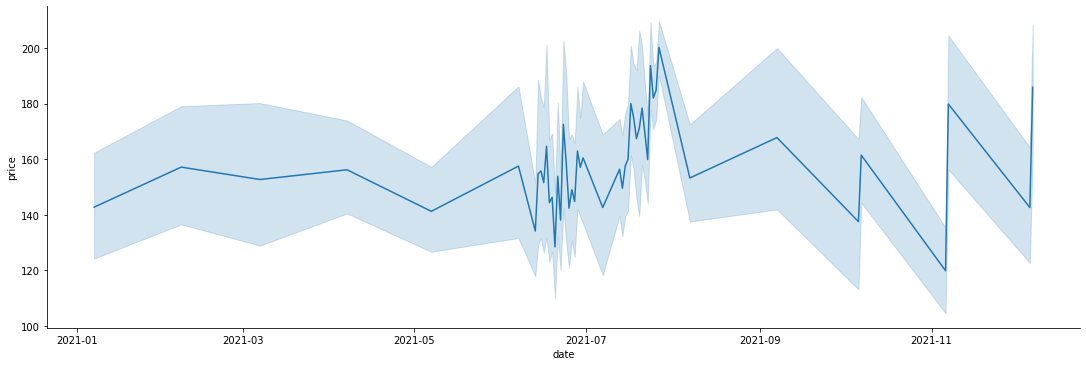

In [22]:
sns.relplot(kind = 'line', data = df_train, x = 'date', y = 'price', aspect = 3)

Considerig the time serie of the price with respect to the ad date, we cannot extract any valuable pattern.

We will use one hot encoding for `category, energy, color, papers, transmission, offer`.

We prefer using ordinal encoding for `wilaya, town, brand, model`, because there are many values and so we can learn relationships between them.

# Preparing pipeline

In [23]:
# Log tranformer for range
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.log(X)

In [24]:
full_pipeline = ColumnTransformer([
    ('log_std', Pipeline([
        ('log', LogTransformer()),
        ('std_scaler', StandardScaler())
        ]), ['range']),
    ('std', Pipeline([
        ('std_scaler', StandardScaler())
        ]), ['volume', 'horses']),
    ('pass', 'passthrough', ['year', 'phares antibrouillard', 
                            'toit ouvrant', 'phares xénon', 
                             'climatisation', 'retroviseurs électriques', 
                             'abs', 'alarme', 'vitres éléctriques', 
                             'direction assisstée', 'esp', 'feux du jour', 
                             'jantes alliage', 'radar de recul']),
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore'), ['category', 'energy', 'color', 'papers', 'transmission', 'offer']),
    ('ordi', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), ['wilaya', 'town', 'brand', 'model'])
])

In [25]:
train_labels = train_set['price'].copy()
test_labels = test_set['price'].copy()

In [26]:
full_pipeline.fit(df[['range', 'volume', 'horses', 'year', 'phares antibrouillard', 
                            'toit ouvrant', 'phares xénon', 
                             'climatisation', 'retroviseurs électriques', 
                             'abs', 'alarme', 'vitres éléctriques', 
                             'direction assisstée', 'esp', 'feux du jour', 
                             'jantes alliage', 'radar de recul',
                             'category', 'energy', 'color', 'papers', 'transmission', 'offer',
                             'wilaya', 'town', 'brand', 'model']])
train_prepared = full_pipeline.transform(train_set[['range', 'volume', 'horses', 'year', 'phares antibrouillard', 
                            'toit ouvrant', 'phares xénon', 
                             'climatisation', 'retroviseurs électriques', 
                             'abs', 'alarme', 'vitres éléctriques', 
                             'direction assisstée', 'esp', 'feux du jour', 
                             'jantes alliage', 'radar de recul',
                             'category', 'energy', 'color', 'papers', 'transmission', 'offer',
                             'wilaya', 'town', 'brand', 'model']])
test_prepared = full_pipeline.transform(test_set[['range', 'volume', 'horses', 'year', 'phares antibrouillard', 
                            'toit ouvrant', 'phares xénon', 
                             'climatisation', 'retroviseurs électriques', 
                             'abs', 'alarme', 'vitres éléctriques', 
                             'direction assisstée', 'esp', 'feux du jour', 
                             'jantes alliage', 'radar de recul',
                             'category', 'energy', 'color', 'papers', 'transmission', 'offer',
                             'wilaya', 'town', 'brand', 'model']])

# Model Selection

We will use mean absolute error as a metric since there is too many outliers in the dataset, and we do not want the model to penalize large error values.

In [27]:
regressors = []
regressors.append(ElasticNet())
regressors.append(DecisionTreeRegressor(random_state = random_state))
regressors.append(RandomForestRegressor(random_state = random_state))
regressors.append(SVR())
regressors.append(AdaBoostRegressor(random_state = random_state))
regressors.append(ExtraTreesRegressor(random_state = random_state))
regressors.append(GradientBoostingRegressor(random_state = random_state))

cv_results = []
for reg_ in regressors:
    cv_results.append(cross_val_score(reg_, train_prepared, 
                                      train_labels, 
                                      cv = 10, 
                                      scoring = 'neg_mean_absolute_error',
                                      n_jobs = 4))
cv_results = pd.DataFrame(cv_results, index = ['ElasticNet', 'DecisionTreeRegressor', 'RandomForestRegressor',
                                              'SVR', 'AdaBoostRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor']).transpose()

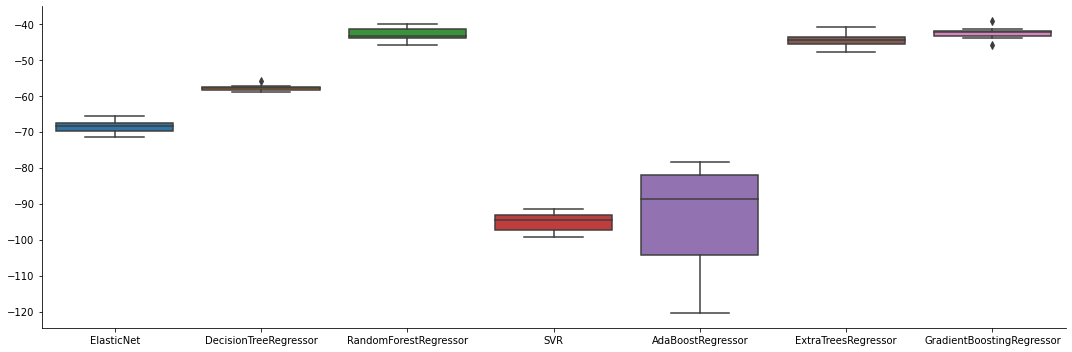

In [28]:
sns.catplot(kind = 'box', data = cv_results, aspect = 3)

In [29]:
cv_results.mean().sort_values(ascending = False)

GradientBoostingRegressor   -42.599102
RandomForestRegressor       -42.922319
ExtraTreesRegressor         -44.598640
DecisionTreeRegressor       -57.918650
ElasticNet                  -68.759204
AdaBoostRegressor           -94.330797
SVR                         -95.163322
dtype: float64

In [30]:
cv_results.std().sort_values(ascending = True)

DecisionTreeRegressor         0.898286
GradientBoostingRegressor     1.743343
ElasticNet                    1.881774
RandomForestRegressor         1.950885
ExtraTreesRegressor           2.191264
SVR                           2.789002
AdaBoostRegressor            15.986948
dtype: float64

We will be keeping GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor and LinearRegression with ElasticNet for an ensemble learning model.

## Hyperparameters tuning 

### LinearRegression

In [31]:
lin_reg = ElasticNet(random_state = random_state)
lin_reg_param_grid = {
    'alpha': [100.0, 50.0, 10.0, 1.0, 0.1, 0.01],
    'l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9, 1]
}

lin_reg_grid_search = GridSearchCV(lin_reg, 
                                   param_grid = lin_reg_param_grid, 
                                   cv = 10, 
                                   scoring = 'neg_mean_absolute_error', 
                                   verbose = 1,
                                   n_jobs = 4)

lin_reg_grid_search.fit(train_prepared, train_labels)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


GridSearchCV(cv=10, estimator=ElasticNet(random_state=42), n_jobs=4,
             param_grid={'alpha': [100.0, 50.0, 10.0, 1.0, 0.1, 0.01],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1]},
             scoring='neg_mean_absolute_error', verbose=1)

In [32]:
lin_reg_grid_search.best_params_

{'alpha': 0.1, 'l1_ratio': 1}

In [33]:
lin_reg_grid_search.best_score_

-59.88344121204629

We reduced ElasticNet error by 8 using gridsearch.

Lasso aggressive regularization helped eliminating less important features.

### GradientBoostingRegressor

In [34]:
grb_reg = GradientBoostingRegressor(random_state = random_state)
grb_reg_param_grid = {
    'learning_rate': [1.0, 0.1, 0.01],
    'n_estimators': [100, 200, 300]
}

grb_reg_grid_search = GridSearchCV(grb_reg, 
                                   param_grid = grb_reg_param_grid, 
                                   cv = 10, 
                                   scoring = 'neg_mean_absolute_error', 
                                   verbose = 1,
                                   n_jobs = 4)

grb_reg_grid_search.fit(train_prepared, train_labels)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=4,
             param_grid={'learning_rate': [1.0, 0.1, 0.01],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=1)

In [35]:
grb_reg_grid_search.best_params_

{'learning_rate': 0.1, 'n_estimators': 300}

In [36]:
grb_reg_grid_search.best_score_

-40.88857053787572

### RandomForestRegressor

In [37]:
rdf_reg = RandomForestRegressor(random_state = random_state)
rdf_reg_param_grid = {
    'n_estimators': [150, 200],
    'max_features': ['sqrt', 'log2', 10],
    "min_samples_split": [2, 5]
}

rdf_reg_grid_search = GridSearchCV(rdf_reg, 
                                   param_grid = rdf_reg_param_grid, 
                                   cv = 10, 
                                   scoring = 'neg_mean_absolute_error', 
                                   verbose = 1,
                                   n_jobs = 4)

rdf_reg_grid_search.fit(train_prepared, train_labels)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=4,
             param_grid={'max_features': ['sqrt', 'log2', 10],
                         'min_samples_split': [2, 5],
                         'n_estimators': [150, 200]},
             scoring='neg_mean_absolute_error', verbose=1)

In [38]:
rdf_reg_grid_search.best_params_

{'max_features': 10, 'min_samples_split': 2, 'n_estimators': 200}

In [39]:
rdf_reg_grid_search.best_score_

-42.86058531261879

### ExtraTreesRegressor

In [40]:
ext_reg = ExtraTreesRegressor(random_state = random_state)
ext_reg_param_grid = {
    'n_estimators': [100, 150],
    'max_features': ['sqrt', 'log2', 10],
    "min_samples_split": [2, 5]
}

ext_reg_grid_search = GridSearchCV(ext_reg, 
                                   param_grid = ext_reg_param_grid, 
                                   cv = 10, 
                                   scoring = 'neg_mean_absolute_error', 
                                   verbose = 1,
                                   n_jobs = 4)

ext_reg_grid_search.fit(train_prepared, train_labels)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


GridSearchCV(cv=10, estimator=ExtraTreesRegressor(random_state=42), n_jobs=4,
             param_grid={'max_features': ['sqrt', 'log2', 10],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 150]},
             scoring='neg_mean_absolute_error', verbose=1)

In [41]:
ext_reg_grid_search.best_params_

{'max_features': 10, 'min_samples_split': 2, 'n_estimators': 150}

In [42]:
ext_reg_grid_search.best_score_

-46.849884112005626

In [43]:
best_regressors = [('LinearRegression', lin_reg_grid_search.best_estimator_),
                    ('GradientBoostingRegressor', grb_reg_grid_search.best_estimator_),
                    ('RandomForestRegressor', rdf_reg_grid_search.best_estimator_),
                    ('ExtraTreesRegressor', ext_reg_grid_search.best_estimator_)
                   ]

<AxesSubplot:>

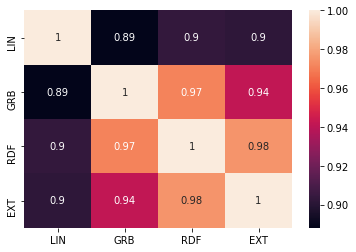

In [44]:
test_prediction_lin_reg = pd.Series(best_regressors[0][1].predict(test_prepared), name = 'LIN')
test_prediction_grb_reg = pd.Series(best_regressors[1][1].predict(test_prepared), name = 'GRB')
test_prediction_rdf_reg = pd.Series(best_regressors[2][1].predict(test_prepared), name = 'RDF')
test_prediction_ext_reg = pd.Series(best_regressors[3][1].predict(test_prepared), name = 'EXT')

ensemble_results = pd.concat([test_prediction_lin_reg, test_prediction_grb_reg, 
                              test_prediction_rdf_reg, test_prediction_ext_reg], axis = 1)

sns.heatmap(ensemble_results.corr(), annot = True)

The models make almost the same error, we should not expect ensemble learning algorithms to do any better.

In [45]:
score_lin = mean_absolute_error(test_prediction_lin_reg, test_labels)
score_grb = mean_absolute_error(test_prediction_grb_reg, test_labels)
score_rdf = mean_absolute_error(test_prediction_rdf_reg, test_labels)
score_ext = mean_absolute_error(test_prediction_ext_reg, test_labels)

print('LinearRegression : ' + str(score_lin) + '\n' +
      'GradientBoostingRegressor : ' + str(score_grb) + '\n' +
      'RandomForestRegressor : ' + str(score_rdf) + '\n' +
      'ExtraTreesRegressor : ' + str(score_ext) + '\n')

LinearRegression : 57.689425012561735
GradientBoostingRegressor : 38.16060239025482
RandomForestRegressor : 40.41420068688439
ExtraTreesRegressor : 44.579472540333356



No overfitting which is a really good news 

In [46]:
vot_reg = VotingRegressor(estimators = best_regressors)
score_vot = cross_val_score(vot_reg, 
                            train_prepared, 
                            train_labels, 
                            cv = 10, 
                            scoring = 'neg_mean_absolute_error',
                            n_jobs = 4)
print("vot:        mean_cv_score: " + str(score_vot.mean()) + " std_cv_score: " + str(score_vot.std()))

vot:        mean_cv_score: -44.1780456812546 std_cv_score: 1.2194681319528369


In [47]:
vot_reg.fit(train_prepared, train_labels)

VotingRegressor(estimators=[('LinearRegression',
                             ElasticNet(alpha=0.1, l1_ratio=1,
                                        random_state=42)),
                            ('GradientBoostingRegressor',
                             GradientBoostingRegressor(n_estimators=300,
                                                       random_state=42)),
                            ('RandomForestRegressor',
                             RandomForestRegressor(max_features=10,
                                                   n_estimators=200,
                                                   random_state=42)),
                            ('ExtraTreesRegressor',
                             ExtraTreesRegressor(max_features=10,
                                                 n_estimators=150,
                                                 random_state=42))])

In [48]:
test_prediction = vot_reg.predict(test_prepared)
mean_absolute_error(test_prediction, test_labels)

41.96915326079668

In [49]:
stack_lin_reg = StackingRegressor(estimators = best_regressors, n_jobs = 4)
score_stack_lin = cross_val_score(stack_lin_reg, 
                                  train_prepared, 
                                  train_labels, 
                                  cv = 10, 
                                  scoring = 'neg_mean_absolute_error',
                                  n_jobs = 4)
print("stack_lin:  mean_cv_score: " + str(score_stack_lin.mean()) + " std_cv_score: " + str(score_stack_lin.std()))

stack_lin:  mean_cv_score: -39.77688475618445 std_cv_score: 1.5442434993081877


In [50]:
stack_lin_reg.fit(train_prepared, train_labels)

StackingRegressor(estimators=[('LinearRegression',
                               ElasticNet(alpha=0.1, l1_ratio=1,
                                          random_state=42)),
                              ('GradientBoostingRegressor',
                               GradientBoostingRegressor(n_estimators=300,
                                                         random_state=42)),
                              ('RandomForestRegressor',
                               RandomForestRegressor(max_features=10,
                                                     n_estimators=200,
                                                     random_state=42)),
                              ('ExtraTreesRegressor',
                               ExtraTreesRegressor(max_features=10,
                                                   n_estimators=150,
                                                   random_state=42))],
                  n_jobs=4)

In [51]:
test_prediction = stack_lin_reg.predict(test_prepared)
mean_absolute_error(test_prediction, test_labels)

37.453647170722284

In [52]:
stack_tree_reg = StackingRegressor(estimators = best_regressors, final_estimator = DecisionTreeRegressor(), n_jobs = 4)
score_stack_tree = cross_val_score(stack_lin_reg, 
                                   train_prepared, 
                                   train_labels,
                                   cv = 10, 
                                   scoring = 'neg_mean_absolute_error',
                                   n_jobs = 4)
print("stack_tree: mean_cv_score: " + str(score_stack_tree.mean()) + " std_cv_score: " + str(score_stack_tree.std()))

stack_tree: mean_cv_score: -39.77688475618445 std_cv_score: 1.5442434993081877


In [53]:
stack_tree_reg.fit(train_prepared, train_labels)

StackingRegressor(estimators=[('LinearRegression',
                               ElasticNet(alpha=0.1, l1_ratio=1,
                                          random_state=42)),
                              ('GradientBoostingRegressor',
                               GradientBoostingRegressor(n_estimators=300,
                                                         random_state=42)),
                              ('RandomForestRegressor',
                               RandomForestRegressor(max_features=10,
                                                     n_estimators=200,
                                                     random_state=42)),
                              ('ExtraTreesRegressor',
                               ExtraTreesRegressor(max_features=10,
                                                   n_estimators=150,
                                                   random_state=42))],
                  final_estimator=DecisionTreeRegressor(), n_jobs=4)

In [54]:
test_prediction = stack_tree_reg.predict(test_prepared)
mean_absolute_error(test_prediction, test_labels)

57.7297433903577

As expected, ensemble learning did not perform that well. But we still got some improvement.

We will keep stacking regressor with linear regression as final predictor.

In [55]:
full_model = Pipeline([
    ('preprocessing', full_pipeline),
    ('model', stack_lin_reg)
])

The model is dump file is too large to be hosted on github. I you want to reproduce the model you just have to run this notebook, and make sure your create `models` directory beforehand.

In [56]:
dump(full_model, os.path.abspath('models/price_estimator.joblib'))

['/home/ayoub/Documents/ouedkniss_cars_pricing/cars_price/models/price_estimator.joblib']